In [ ]:
import numpy as np
from music21 import midi, note, stream, instrument, meter, key, duration, tempo
from music21.note import Rest
import random

print(1)
mf = midi.MidiFile()
mf.open("Bolero-Ravel_Flute_Bat_Strings.mid")
mf.read()
mf.close()
print(len(mf.tracks))
s = stream.Stream()
s.append(midi.translate.midiFileToStream(mf))
s


In [ ]:
def play(score):
    #Shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()

In [ ]:
s.show()

In [39]:
new_stream = stream.Stream()
ts = meter.TimeSignature('3/4')
new_stream.append(tempo.MetronomeMark(number = 72))

new_stream.insert(0, ts)
new_stream.insert(0, instrument.Guitar())

initial_probabilities = np.array([3, 1, 2, 1, 2, 1], dtype = 'float32') / 10

part_nb = 0

duration = 0
for parts in s:
    for part in parts:
        duration = 0
        new_part = stream.Part()
        probabilities = initial_probabilities
        for element in part.flat.notesAndRests[0:100]:
            elem_duration = element.duration.quarterLength

            if (duration + elem_duration >= 6):
                probabilities *= 1.3

            duration = (duration + elem_duration) % 6

            if (random.random() < probabilities[int(duration)] * elem_duration):
                new_part.append(element)
            else:
                r = note.Rest()
                r.duration = element.duration
                new_part.append(r)
        new_stream.insert(0, new_part)



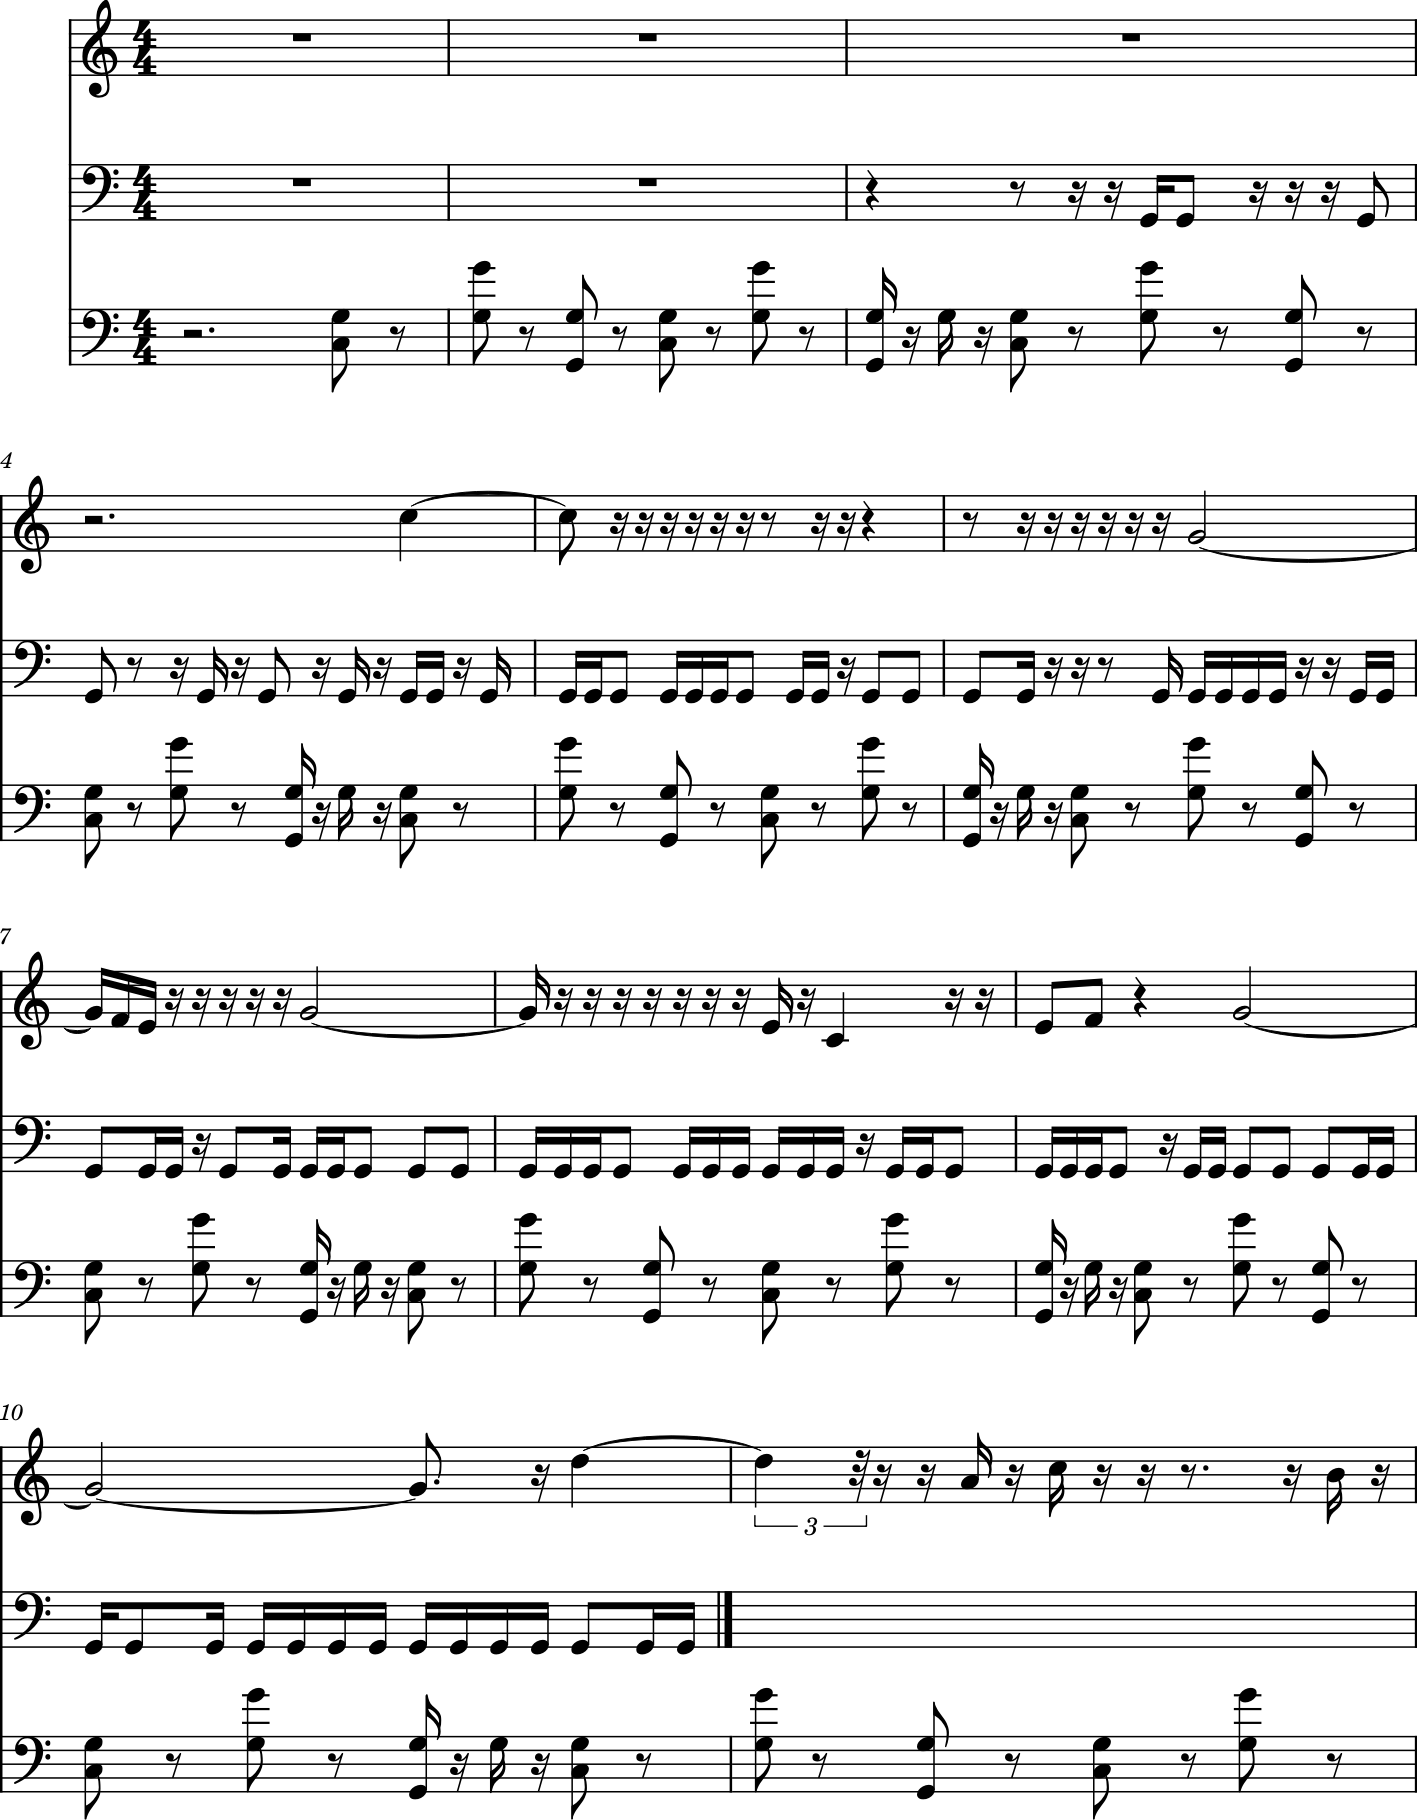

In [40]:
new_stream.show()

In [41]:

play(new_stream)

In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
TIMESTEPS = 10
TIME_HORIZON = 1.0

In [44]:
def brownian_motion(dimensions=1, start_value = 0, time_horizon=TIME_HORIZON, timesteps= TIMESTEPS):

    times = np.linspace(0.0, time_horizon, timesteps)
    step_length = times[1] - times[0]

    # as brownian motion at time t1 - brownian motion at time t0 ~ Normal(mean = 0, variance = t1-t0)
    # scale is the standard deviation, so we take the square root of the step_length
    diff_b = np.random.normal(size = (timesteps-1, dimensions), scale = np.sqrt(step_length)) 

    brownian_motion = np.zeros(shape=(timesteps,dimensions))
    brownian_motion[0,:] = np.full((1, dimensions), start_value)

     # the rest of the values of brownian motion are the cumulative sum of normal values
    brownian_motion[1:,:] = np.cumsum(diff_b, axis = 0) + start_value

    #brownian_motion = np.cumsum(diff_b).append(0)
    return times, brownian_motion

<function matplotlib.pyplot.show(close=None, block=None)>

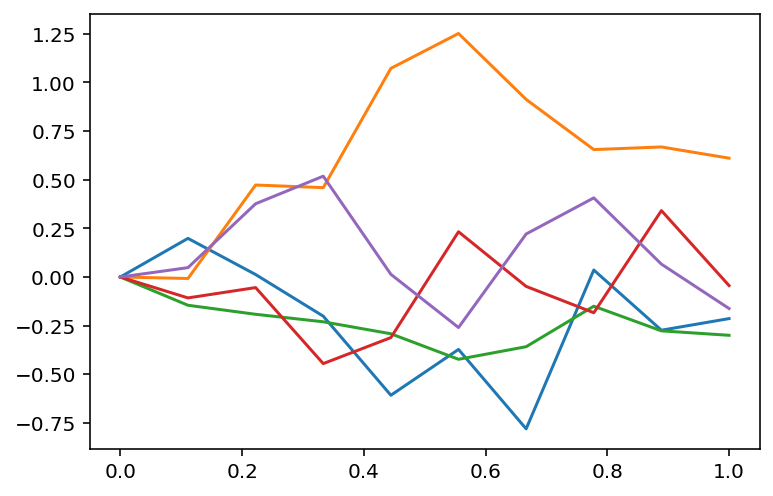

In [45]:
times, brownian_motion_arr = brownian_motion(dimensions=5)
plt.plot(times, brownian_motion_arr)
plt.show